# OpenPIV masking tutorial


In this tutorial we focus on the two ways you can use image masking in OpenPIV. 

**Definitions**:

1. _static mask_ - an image with regions that should not be processed are marked as 1 (white color in black and white image or True) and regions that are processed are unmasked (zeros, False)

2. _dynamic mask_ - every pair of images (frame A, B) are processed to find out the region that has to be masked, e.g. a fish body around which we want to analyze PIV vectors. An average mask is then applied to both frames and PIV analysis 


OpenPIV uses these masks in two ways: 

1. masked image regions are set to zero or completely black. `frame_a[image_mask] = 0`
2. PIV analysis in a completely black interrogation windows result in a zero peak and marked as invalid. 
3. in addition, the image mask is converted in a set of `x,y` coordinates on a PIV grid that mark the masked region in the vector field. These `mask_coords` are propagating through the window deformation and stored with the `x,y,u,v,mask` in the ASCII result files. The vector fields `u,v` are `numpy.MaskedArray` so the masked regions are invalid and should not appear in the plot. They could be also replaced by zeros or `NaN` if needed. 

In [1]:
from openpiv import tools, pyprocess, validation, filters, scaling 

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import imageio
import importlib_resources
import pathlib

In [2]:

path = importlib_resources.files('openpiv') # pathlib.Path type

In [3]:

frame_a  = tools.imread( path / 'data' / 'test3' / 'pair_4_frame_0.jpg' )
frame_b  = tools.imread( path / 'data' / 'test3' / 'pair_4_frame_1.jpg' ) 


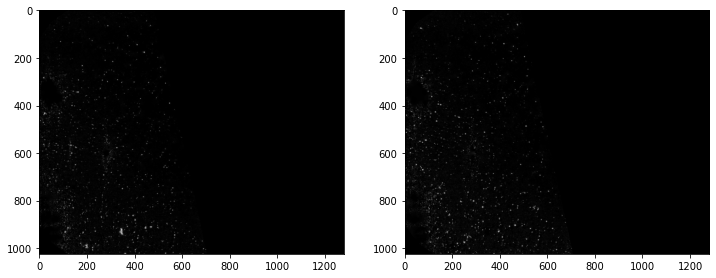

In [4]:

fig,ax = plt.subplots(1,2,figsize=(12,10))
ax[0].imshow(frame_a,cmap='gray');
ax[1].imshow(frame_b,cmap='gray');

In [5]:
# use scikit-image to stretch with CLAHE
from skimage.exposure import rescale_intensity, equalize_adapthist, equalize_hist


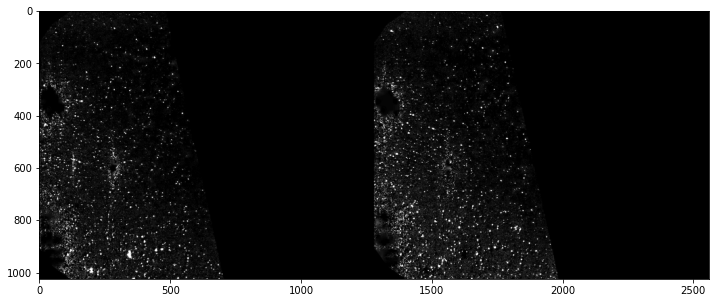

In [6]:
frame_a = rescale_intensity(frame_a, (0,50))
frame_b = rescale_intensity(frame_b, (0,50))
plt.figure(figsize=(12,12))
plt.imshow(np.c_[frame_a, frame_b], cmap='gray')

### Processing

In this tutorial, we are going to use the `extended_search_area_piv` function, wich is a standard PIV cross-correlation algorithm.

This function allows the search area (`search_area_size`) in the second frame to be larger than the interrogation window in the first frame (`window_size`). Also, the search areas can overlap (`overlap`).


The `extended_search_area_piv` function will return three arrays.
1. The `u` component of the velocity vectors
2. The `v` component of the velocity vectors
3. The signal-to-noise ratio (S2N) of the cross-correlation map of each vector. The higher the S2N of a vector, the higher the probability that its magnitude and direction are correct.

In [7]:
frame_a = equalize_adapthist(frame_a, 15)

In [8]:
winsize = 32 # pixels, interrogation window size in frame A
searchsize = 38  # pixels, search area size in frame B
overlap = 17 # pixels, 50% overlap
dt = 0.02 # sec, time interval between the two frames

u0, v0, sig2noise = pyprocess.extended_search_area_piv(
    frame_a.astype(np.int32), 
    frame_b.astype(np.int32), 
    window_size=winsize, 
    overlap=overlap, 
    dt=dt, 
    search_area_size=searchsize, 
    sig2noise_method='peak2peak',
)

The function `get_coordinates` finds the center of each interrogation window. This will be useful later on when plotting the vector field.

In [9]:
x, y = pyprocess.get_coordinates( 
    image_size=frame_a.shape, 
    search_area_size=searchsize, 
    overlap=overlap,
)

### Post-processing

Strictly speaking, we are ready to plot the vector field. But before we do that, we can perform some convenient pos-processing.

To start, lets use the function `sig2noise_val` to get a mask indicating which vectors have a minimum amount of S2N. Vectors below a certain threshold are substituted by `NaN`. If you are not sure about which threshold value to use, try taking a look at the S2N histogram with:

`plt.hist(sig2noise.flatten())`

In [10]:
invalid_mask = validation.sig2noise_val( 
    sig2noise, 
    threshold = 1.05,
)

Another useful function is `replace_outliers`, which will find outlier vectors, and substitute them by an average of neighboring vectors. The larger the `kernel_size` the larger is the considered neighborhood. This function uses an iterative image inpainting algorithm. The amount of iterations can be chosen via `max_iter`.

In [11]:
u2, v2, _ = filters.replace_outliers( 
    u0, v0,
    invalid_mask,
    method='localmean', 
    max_iter=3, 
    kernel_size=3,
)

Next, we are going to convert pixels to millimeters, and flip the coordinate system such that the origin becomes the bottom left corner of the image.

In [12]:
# convert x,y to mm
# convert u,v to mm/sec

x, y, u3, v3 = scaling.uniform(
    x, y, u2, v2, 
    scaling_factor = 96.52,  # 96.52 pixels/millimeter
)

# 0,0 shall be bottom left, positive rotation rate is counterclockwise
x, y, u3, v3 = tools.transform_coordinates(x, y, u3, v3)

### Results

The function `save` is used to save the vector field to a ASCII tabular file. The coordinates and S2N mask are also saved.

In [13]:
tools.save(x, y, u3, v3, invalid_mask, 'exp1_001.txt' )

Finally, the vector field can be plotted with `display_vector_field`. 

Vectors with S2N bellow the threshold are displayed in red.

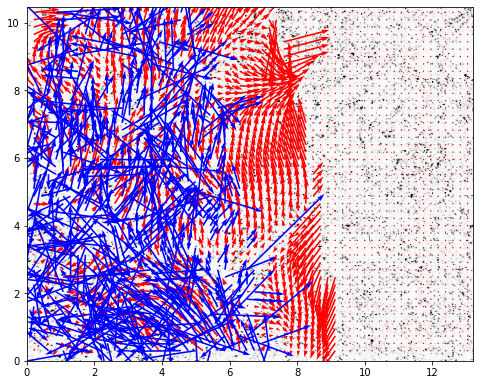

In [14]:
fig, ax = plt.subplots(figsize=(8,8))
tools.display_vector_field(
    pathlib.Path('exp1_001.txt'), 
    ax=ax, scaling_factor=96.52, 
    scale=50, # scale defines here the arrow length
    width=0.0035, # width is the thickness of the arrow
    on_img=True, # overlay on the image
    image_name= str(path / 'data'/'test1'/'exp1_001_a.bmp'),
);

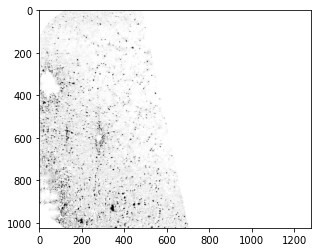

In [18]:
plt.imshow(255 - frame_a,'gray')

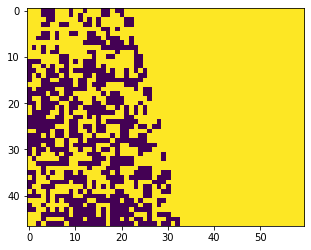

In [19]:
plt.imshow(invalid_mask)

(-0.5, 63.025, 49.375, -0.5)

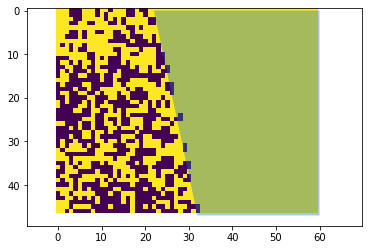

In [29]:
import matplotlib.pyplot as plt
import numpy as np

from matplotlib.patches import Polygon
from matplotlib.collections import PatchCollection

# Circle coordinates (100 points around the circle)
# t = np.linspace(0, 2 * np.pi, 100).reshape(100,1)
# coords = np.concatenate((np.cos(t), np.sin(t)), axis=1)\

ax = plt.axes()

ax.imshow(invalid_mask)

coords = [
    [22,0],
    [32,invalid_mask.shape[0]],
    [invalid_mask.shape[1],invalid_mask.shape[0]],
    [invalid_mask.shape[1],0]
    ]

polygons = [];
polygons.append(Polygon(coords))
p = PatchCollection(polygons, alpha=0.4)
ax.add_collection(p)
ax.axis('equal')

In [30]:
from openpiv.preprocess import points_in_poly, prepare_mask_on_grid

In [25]:
invalid_mask.shape

(47, 60)

In [40]:
x[0,:]

array([ 0.20721094,  0.42478243,  0.64235392,  0.8599254 ,  1.07749689,
        1.29506838,  1.51263987,  1.73021136,  1.94778284,  2.16535433,
        2.38292582,  2.60049731,  2.81806879,  3.03564028,  3.25321177,
        3.47078326,  3.68835475,  3.90592623,  4.12349772,  4.34106921,
        4.5586407 ,  4.77621218,  4.99378367,  5.21135516,  5.42892665,
        5.64649814,  5.86406962,  6.08164111,  6.2992126 ,  6.51678409,
        6.73435557,  6.95192706,  7.16949855,  7.38707004,  7.60464153,
        7.82221301,  8.0397845 ,  8.25735599,  8.47492748,  8.69249896,
        8.91007045,  9.12764194,  9.34521343,  9.56278492,  9.7803564 ,
        9.99792789, 10.21549938, 10.43307087, 10.65064235, 10.86821384,
       11.08578533, 11.30335682, 11.52092831, 11.73849979, 11.95607128,
       12.17364277, 12.39121426, 12.60878574, 12.82635723, 13.04392872])

In [46]:
points_in_poly([x.ravel(), y.ravel()],np.array(coords))

array([False, False])

In [33]:
np.array(coords)

array([[22,  0],
       [32, 47],
       [60, 47],
       [60,  0]])